In [125]:
# !pip install catboost
# !pip install yellowbrick
# !pip install ipywidgets
# !pip install pandas-profiling
# !pip install joblib
# !jupyter nbextension enable --py widgetsnbextension

In [126]:
import os
import random
import sqlite3
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import pandas_profiling as pp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import stats
from scipy.stats import norm
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import catboost
import tensorflow as tf
from catboost import CatBoostRegressor
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.metrics import max_error
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae, explained_variance_score

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

import joblib
from google.colab import files

%matplotlib inline

In [127]:
database = sqlite3.connect(os.path.join(os.getcwd(), "fypdbmain.sqlite"))

In [128]:
tickers = {
    "EVs": "TSLA",
    "Finance": "MS",
    "Tech": "GOOGL"
}

categories = ["EVs","Finance","Tech"]

tableName = {
    "EVs": "evDataAggr",
    "Finance": "financeDataAggr",
    "Tech": "techDataAggr"
}


In [129]:
def load_datasets(tickers, categories):
    tweet_dfs = dict()
    
    stock_dfs = dict()
    for category in categories:
      ticker = tickers[category]
      #ToDo make this line general
      tweet_df = pd.read_sql_query(f"SELECT * from {tableName[category]}",database)
      tweet_df = tweet_df.drop(columns = ['category'])
      tweet_df["date"] = tweet_df["date"].astype("datetime64")
      tweet_df["count"] = tweet_df["count"].astype("int32")
      tweet_df["neg_count"] = tweet_df["neg_count"].astype("int32")
      tweet_df["neu_count"] = tweet_df["neu_count"].astype("int32")
      tweet_df["pos_count"] = tweet_df["pos_count"].astype("int32")
      tweet_df["neg_score"] = tweet_df["neg_score"].astype("float64")
      tweet_df["neu_score"] = tweet_df["neu_score"].astype("float64")
      tweet_df["pos_score"] = tweet_df["pos_score"].astype("float64")
      tweet_df["wt_neg"] = tweet_df["wt_neg"].astype("float64")
      tweet_df["wt_neu"] = tweet_df["wt_neu"].astype("float64")
      tweet_df["wt_pos"] = tweet_df["wt_pos"].astype("float64")
      #tweet_df["mood"] = (tweet_df["wted_pos"] - tweet_df["wted_neg"]) / (tweet_df["wted_pos"] + tweet_df["wted_neu"] + tweet_df["wted_neg"])

      if(ticker!='GOOGL'):
        tweet_df["neg_count"] = -1 * tweet_df["neg_count"]
        tweet_df["neg_score"] = -1 * tweet_df["neg_score"]
        tweet_df["wt_neg"] = -1 * tweet_df["wt_neg"]
        tweet_df["neu_count"] = -1 * tweet_df["neu_count"]
        tweet_df["neu_score"] = -1 * tweet_df["neu_score"]
        tweet_df["wt_neu"] = -1 * tweet_df["wt_neu"]
        tweet_df["pos_count"] = -1 * tweet_df["pos_count"]
        tweet_df["pos_score"] = -1 * tweet_df["pos_score"]
        tweet_df["wt_pos"] = -1 * tweet_df["wt_pos"]

      tweet_dfs[ticker] = tweet_df.copy(deep=True)

      stock_df = pd.read_sql_query(f"SELECT * from stockDataAggr where category ='{category}'",database)
      stock_df = stock_df.drop(columns = ['category', 'ticker','aggrPercent'])

      stock_df["stockDate"] = stock_df["stockDate"].astype("datetime64")
      stock_df["open"] = stock_df["open"].astype("float64")
      stock_df["close"] = stock_df["close"].astype("float64")
      stock_df["high"] = stock_df["high"].astype("float64")
      stock_df["low"] = stock_df["low"].astype("float64")

      stock_df.rename(columns = {'stockDate': 'date'}, inplace = True)
      stock_dfs[ticker] = stock_df.copy(deep=True)
      del tweet_df, stock_df
            
    return tweet_dfs, stock_dfs

In [130]:
tweet_dfs, stock_dfs = load_datasets(tickers, categories)

In [131]:
tweet_dfs["MS"]

,date,neg_count,neu_count,pos_count,neg_score,neu_score,pos_score,wt_neg,wt_neu,wt_pos,count
0,2022-08-02,-766,-127,-303,-336.0,-115.406570,-196.611622,-239.981812,-152.470932,-293.251112,320
1,2022-08-01,-427,-83,-150,-194.0,-69.494362,-115.738205,-174.767426,-77.543838,-154.309587,195
2,2022-08-03,-1359,-451,-497,-411.0,-285.696716,-395.129700,-274.173561,-417.545763,-535.736023,405
3,2022-08-04,-1479,-361,-744,-374.0,-234.666542,-372.979546,-317.353912,-471.263652,-580.721989,427
4,2022-08-05,-1183,-358,-405,-420.0,-226.413116,-297.240101,-229.346766,-323.883955,-422.728630,436
...,...,...,...,...,...,...,...,...,...,...,...
238,2023-03-27,-616,-148,-284,-184.0,-148.681401,-274.666202,-192.652397,-234.922952,-482.123691,318
239,2023-03-28,-187,-54,-97,-36.0,-47.810618,-95.097759,-44.091623,-75.500702,-112.091591,47
240,2023-03-29,-498,-126,-172,-200.0,-123.980578,-195.046607,-178.972815,-142.884097,-225.294882,203
241,2023-03-30,-522,-104,-277,-141.0,-109.790652,-237.557411,-174.651938,-117.151378,-262.639870,207


In [132]:
stock_dfs["MS"]

,date,open,close,high,low
0,2022-08-01,83.660004,84.089996,84.540001,83.010002
1,2022-08-02,83.330002,83.529999,84.589996,82.959999
2,2022-08-03,84.680000,85.050003,85.589996,84.120003
3,2022-08-04,85.199997,85.360001,85.650002,84.800003
4,2022-08-05,84.989998,86.129997,86.709999,84.709999
...,...,...,...,...,...
238,2023-03-27,86.059998,84.639999,86.320000,84.360001
239,2023-03-28,84.559998,84.879997,85.169998,83.930000
240,2023-03-29,85.930000,86.239998,86.349998,85.349998
241,2023-03-30,87.260002,86.110001,87.610001,85.459999


In [133]:
def merge_datasets(categories, tickers, ticker_dfs, stock_dfs):
    merged_dfs = dict()
    
    for category in categories:
        ticker = tickers[category]
            
        temp_tweet_df = tweet_dfs[ticker].copy(deep=True)
        temp_stock_df = stock_dfs[ticker].copy(deep=True)

        temp_merged_df = pd.merge(temp_stock_df, temp_tweet_df, on=['date'])
        temp_merged_df = temp_merged_df.sort_values(by=['date']).reset_index(drop=True)
        
        
        merged_dfs[ticker] = temp_merged_df.copy(deep=True)
        
        print(f"Data dimensions for {ticker}:", temp_merged_df.shape, "\n")
        
        del temp_tweet_df, temp_stock_df, temp_merged_df
            
    return merged_dfs

In [134]:
def normalize_datasets(categories, tickers, merged_dfs, reduced=False, output_label='close'):
    norm_dfs = dict()
    
    scaler = MinMaxScaler()
    
    for category in categories:
        
        ticker = tickers[category]
        temp_norm_df = merged_dfs[ticker].copy(deep=True)
        
        temp_norm_df = temp_norm_df.drop(columns=['date'])

        temp_norm_df = scaler.fit_transform(temp_norm_df)

        if(reduced == False):

          temp_norm_df = pd.DataFrame(temp_norm_df, columns = [ 'open', 'close', 'high', 'low', \
                                                                'count','neg_score','neu_score', 'pos_score', \
                                                                'wt_neg', 'wt_neu', 'wt_pos', \
                                                                'neg_count', 'neu_count', 'pos_count'])
        else:
          #columns = ['open', 'wt_neg', 'wt_neu', 'wt_pos','prev_open','prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', output_label]
          columns = ['open', 'prev_open','prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', output_label]
          temp_norm_df = pd.DataFrame(temp_norm_df, columns = columns)
        
        
        norm_dfs[ticker] = temp_norm_df.copy(deep=True)
        
        print(f"Data dimensions for {ticker}:", temp_norm_df.shape, "\n")
        
        del temp_norm_df
            
    return norm_dfs

In [135]:
merged_dfs = merge_datasets(categories, tickers, tweet_dfs, stock_dfs)

Data dimensions for TSLA: (243, 15) 

Data dimensions for MS: (243, 15) 

Data dimensions for GOOGL: (243, 15) 



In [136]:
def plot_corr_heatmaps(categories, tickers, norm_dfs):
    cmaps = ['YlOrBr', 'YlOrRd', 'YlGnBu', 'PuBuGn', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu']
    for category in categories:
        ticker=tickers[category]
        plt.figure(figsize=(10,6))
        sns.heatmap(norm_dfs[ticker].corr('spearman'),cmap='RdYlGn',annot=True, linewidths=0.2)
        plt.title(f'Correlation Heatmap For {ticker}', fontsize=14)

        plt.show()

In [137]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

In [138]:
def RMSE(y_true, y_pred):
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    
    return round(RMSE, 6)

In [139]:
def print_metrics(model, X_train, X_test, y_test):
    
    n_points = X_train.shape[0] #number of datapoints
    n_features = X_train.shape[1] #number of features

    #predict probabilities for test set
    y_hat = model.predict(X_test)

    rmse_val = RMSE(y_test.reshape(-1,1), y_hat)
    print('RMSE:\t\t\t%f' % rmse_val)
    
    mse_val = mse(y_test.reshape(-1, 1), y_hat)
    print('MSE:\t\t\t%f' % mse_val)
    
    mae_val = mae(y_test.reshape(-1, 1), y_hat)
    print('MAE:\t\t\t%f' % mae_val)

    r2 = r2_score(y_test.reshape(-1,1), y_hat)
    print('R2 Score:\t\t%f' % r2)

    adj_r2 = 1-(1-r2)*(n_points-1)/(n_points-n_features-1)
    print('Adj. R2 Score:\t\t%f' % adj_r2)
    
    exp_var_score = explained_variance_score(y_test.reshape(-1,1), y_hat)
    print('Exp. Variance Score:\t%f' % exp_var_score)

    max_err = max_error(y_test.reshape(-1,1), y_hat)
    print('Max Error:\t\t%f' % max_err)

In [140]:
def plot_prediction_graph(model, X_train, X_test, y_test, output_labels_unscaled, dates, ticker,output_label='close'):
    predicted  = model.predict(X_test)
    test_label = y_test.reshape(-1,1)
    predicted = np.array(predicted).reshape(-1,1)
    print("Predicted","\t","Value")
    for i in range(len(predicted)):
      print(predicted[i],"\t",test_label[i])
    len_t = len(X_train)

    for j in range(len_t , len_t + len(X_test)):
        temp = output_labels_unscaled[j]
        test_label[j - len_t] = test_label[j - len_t] * temp + temp
        predicted[j - len_t] = predicted[j - len_t] * temp + temp

    plt.figure(figsize=(15, 10))
    plt.plot(dates, predicted, color = 'green', label = 'Predicted ' + output_label, linewidth=2)
    plt.plot(dates, test_label, color = 'red', label = 'Actual ' + output_label, linewidth=2)
    plt.title('Stock - '+output_label+' Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y')) 
    plt.legend(loc='best')
    

    plt.savefig(os.path.join(os.getcwd(),f'images/catboost-prediction-graph-{ticker}'), transparent=True, dpi=400)
    
    plt.show()

In [141]:
def print_feature_importance(model, df_cols, ticker):
    sorted_feature_importance = model.feature_importances_.argsort()

    plt.figure(figsize=(10, 5))
    plt.barh(df_cols[sorted_feature_importance], 
             model.feature_importances_[sorted_feature_importance], 
             color = 'turquoise')
    plt.title(f"CatBoost Feature Importance - {ticker}")
    plt.show()

In [142]:
def get_train_test_set(ticker, norm_df, output_label = 'close'):
    temp_df = norm_df.copy(deep = True)
    output_values = temp_df.loc[:, output_label]
    temp_df.drop(columns = [output_label], inplace = True)
    
    temp_df = temp_df.to_numpy()
    output_values = output_values.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(temp_df, output_values, \
                                                        test_size = 0.2, random_state = 3, shuffle=False)
    
    Xd_train, Xd_test, yd_train, yd_test = train_test_split(merged_dfs[ticker], merged_dfs[ticker][output_label], \
                                                        test_size = 0.2, random_state = 3, shuffle=False)

    
    test_dates = Xd_test['date'] #Collect Test data dates
    
    while len(test_dates) > len(y_test): #in case the array size is higher for dates
        test_dates = test_dates[:-1].copy()
    
    
    del Xd_train, Xd_test, yd_train, yd_test #Run GC
    del temp_df, output_values #Run GC
    
    return X_train, X_test, y_train, y_test, test_dates

In [143]:
def get_unscaled_output_labels(categories, tickers, dfs, output_label='close'):
    unscaled_op_labels = dict()
    
    for category in categories:
        ticker=tickers[category]
        # print(output_label)
        unscaled_op_labels[ticker] = dfs[ticker].loc[:, output_label].copy(deep=True)

    return unscaled_op_labels

In [144]:
def train_and_test_model(categories, tickers, norm_dfs, unscaled_op_labels, output_label='close'):
#     params = {'depth': 2,
#               'iterations': 200,
#               'learning_rate': 0.03,
#               'l2_leaf_reg': 3}

    params = {
            'eval_metric': 'MAE',
            'iterations': 200,
            'l2_leaf_reg': 10,
            'depth': 4,
            'learning_rate': 0.05,
            'loss_function': 'MAE'
        }


    model = CatBoostRegressor(**params, 
                                 logging_level='Silent', 
                                 random_state=3,
                                )
    
    for category in categories:
        ticker=tickers[category]
        print(f"======CURRENTLY WORKING ON {ticker}======")
        
        X_train, X_test, y_train, y_test, dates = get_train_test_set(ticker, norm_dfs[ticker], 
                                                                      output_label)
        
        model.fit(X_train, y_train)

        joblib.dump(model, 'catboost_model_'+ticker+'-'+output_label)

        # Download the saved model file to your local machine
        files.download('catboost_model_'+ticker+'-'+output_label)
        
        print_feature_importance(model, norm_dfs[ticker].columns.values, ticker)
        print_metrics(model, X_train, X_test, y_test)
        plot_prediction_graph(model, X_train, X_test, y_test, unscaled_op_labels[ticker], dates, ticker,output_label)
        
        
        print(f"======FINISHED WORKING ON {ticker}======")

In [145]:
def append_prev_day_value(categories, tickers, merged_dfs, output_label='close'):
    prev_open_dfs = dict()

    column_to_drop = ['count', 'neg_score', 'neu_score', 'pos_score', 'neg_count', 'neu_count', 'pos_count']
    for i in ['low','high','close']:
      if(i != output_label):
        column_to_drop.append(i)

    
    for category in categories:
        ticker = tickers[category]
    
        t_df = merged_dfs[ticker].copy(deep = True)
        t_df = t_df.drop(columns = column_to_drop)

        t_minus1_df = t_df.copy(deep = True).drop(columns = [output_label])
        t_minus1_df = t_minus1_df.rename(columns = {'open': 'prev_open','wt_neg':'prev_wt_neg', 'wt_neu':'prev_wt_neu', 'wt_pos':'prev_wt_pos'})

        t_minus1_df['date'] = t_minus1_df['date'] + datetime.timedelta(1)

        t_df = t_df.drop(columns=['wt_neg', 'wt_neu', 'wt_pos'])

        prev_open_df = pd.merge(t_df, t_minus1_df, on = ['date'])

        #prev_open_df = prev_open_df[['date', 'open', 'wt_neg', 'wt_neu', 'wt_pos','prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', output_label]]
        prev_open_df = prev_open_df[['date', 'open', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', output_label]]
        
        prev_open_dfs[ticker] = prev_open_df.copy(deep=True)
        
        del prev_open_df #Perform GC

    return prev_open_dfs

# **Predicting Close Value**

In [146]:
both_open_dfs = append_prev_day_value(categories, tickers, merged_dfs, output_label='close')

both_open_dfs['TSLA']

,date,open,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,close
0,2022-08-02,294.003326,301.276672,-16.876412,-26.904634,-41.171774,300.586670
1,2022-08-03,305.000000,294.003326,-22.682993,-25.073643,-37.357318,307.396667
2,2022-08-04,311.000000,305.000000,-2.331892,-6.009396,-13.196395,308.633331
3,2022-08-05,302.670013,311.000000,-1.167563,-2.196746,-3.635691,288.170013
4,2022-08-06,298.840000,302.670013,-16.216868,-16.855830,-160.879937,289.300000
...,...,...,...,...,...,...,...
237,2023-03-27,194.419998,193.720000,-14.594635,-21.290344,-30.107518,191.809998
238,2023-03-28,192.000000,194.419998,-232.793960,-281.636459,-465.958222,189.190002
239,2023-03-29,193.130005,192.000000,-13.191043,-12.029059,-33.769606,193.880005
240,2023-03-30,195.580002,193.130005,-50.816797,-73.301693,-115.862161,195.279999


In [147]:
both_open_norm_dfs = normalize_datasets(categories, tickers, both_open_dfs,True,output_label='close')

Data dimensions for TSLA: (242, 6) 

Data dimensions for MS: (242, 6) 

Data dimensions for GOOGL: (242, 6) 



In [148]:
both_open_norm_dfs['TSLA']

,open,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,close
0,0.915351,0.950208,0.948169,0.984976,0.979141,0.956598
1,0.968051,0.915351,0.930269,0.986030,0.981093,0.990442
2,0.996805,0.968051,0.993008,0.997001,0.993455,0.996587
3,0.956885,0.996805,0.996598,0.999194,0.998347,0.894891
4,0.938530,0.956885,0.950203,0.990759,0.917889,0.900507
...,...,...,...,...,...,...
237,0.438115,0.434760,0.955204,0.988207,0.984802,0.416012
238,0.426518,0.438115,0.282526,0.838391,0.761786,0.402992
239,0.431933,0.426518,0.959531,0.993536,0.982928,0.426300
240,0.443674,0.431933,0.843536,0.958277,0.940923,0.433257


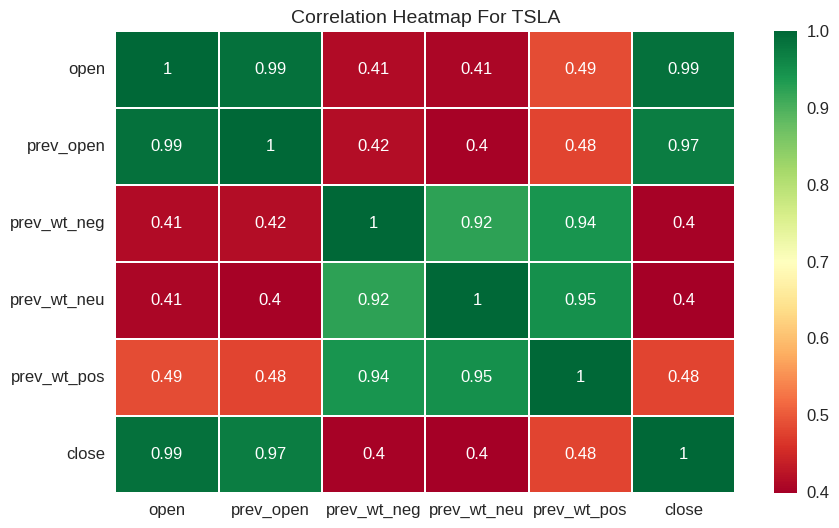

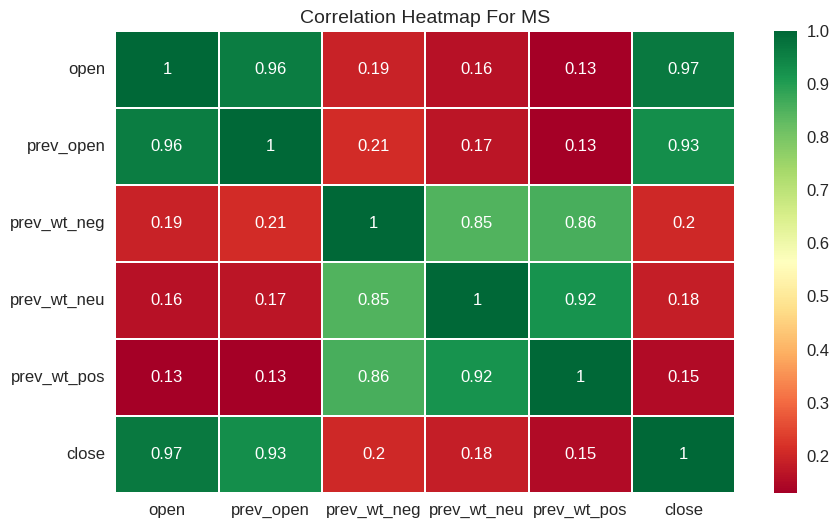

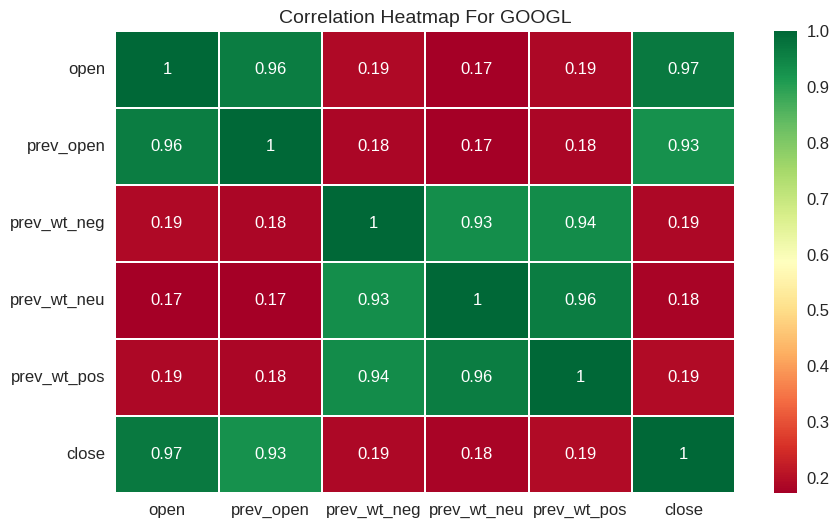

In [149]:
plot_corr_heatmaps(categories, tickers, both_open_norm_dfs)

======CURRENTLY WORKING ON TSLA======


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

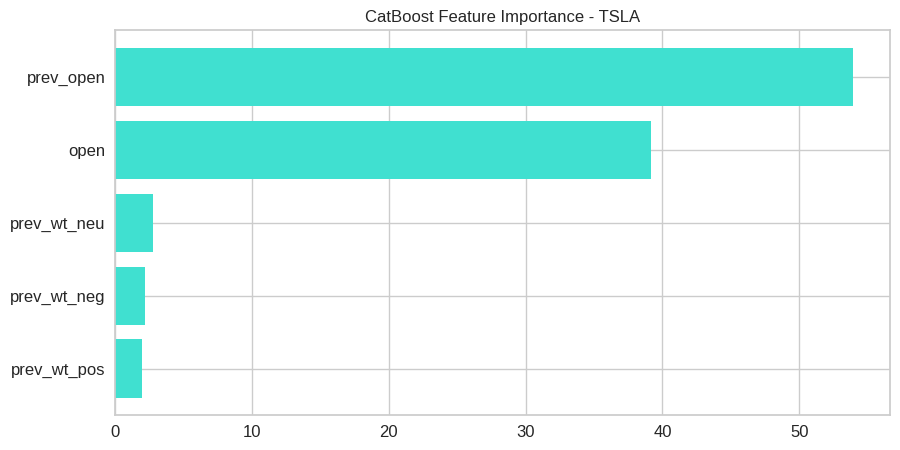

RMSE:			0.032153
MSE:			0.001034
MAE:			0.023722
R2 Score:		0.608224
Adj. R2 Score:		0.597748
Exp. Variance Score:	0.609552
Max Error:		0.096511
Predicted 	 Value
[0.46663138] 	 [0.43564257]
[0.47270626] 	 [0.43285955]
[0.43926242] 	 [0.43007652]
[0.40617301] 	 [0.50268362]
[0.4726247] 	 [0.52748237]
[0.51192696] 	 [0.46685216]
[0.48996543] 	 [0.4980121]
[0.46378802] 	 [0.47082794]
[0.47650168] 	 [0.457211]
[0.46674549] 	 [0.45040253]
[0.4540589] 	 [0.44364374]
[0.45430662] 	 [0.46098797]
[0.46564942] 	 [0.46700132]
[0.4567712] 	 [0.44120864]
[0.46932724] 	 [0.46794552]
[0.45968433] 	 [0.48131397]
[0.46407732] 	 [0.49463275]
[0.47969413] 	 [0.48509097]
[0.5045386] 	 [0.47048008]
[0.42452913] 	 [0.41148987]
[0.40701334] 	 [0.445731]
[0.43527673] 	 [0.43584136]
[0.45518288] 	 [0.43087167]
[0.45624175] 	 [0.42595168]
[0.45294471] 	 [0.39563664]
[0.38306646] 	 [0.36725971]
[0.37645593] 	 [0.32213496]
[0.32297708] 	 [0.32471922]
[0.30680916] 	 [0.32730344]
[0.30353345] 	 [0.32859556]
[0.305

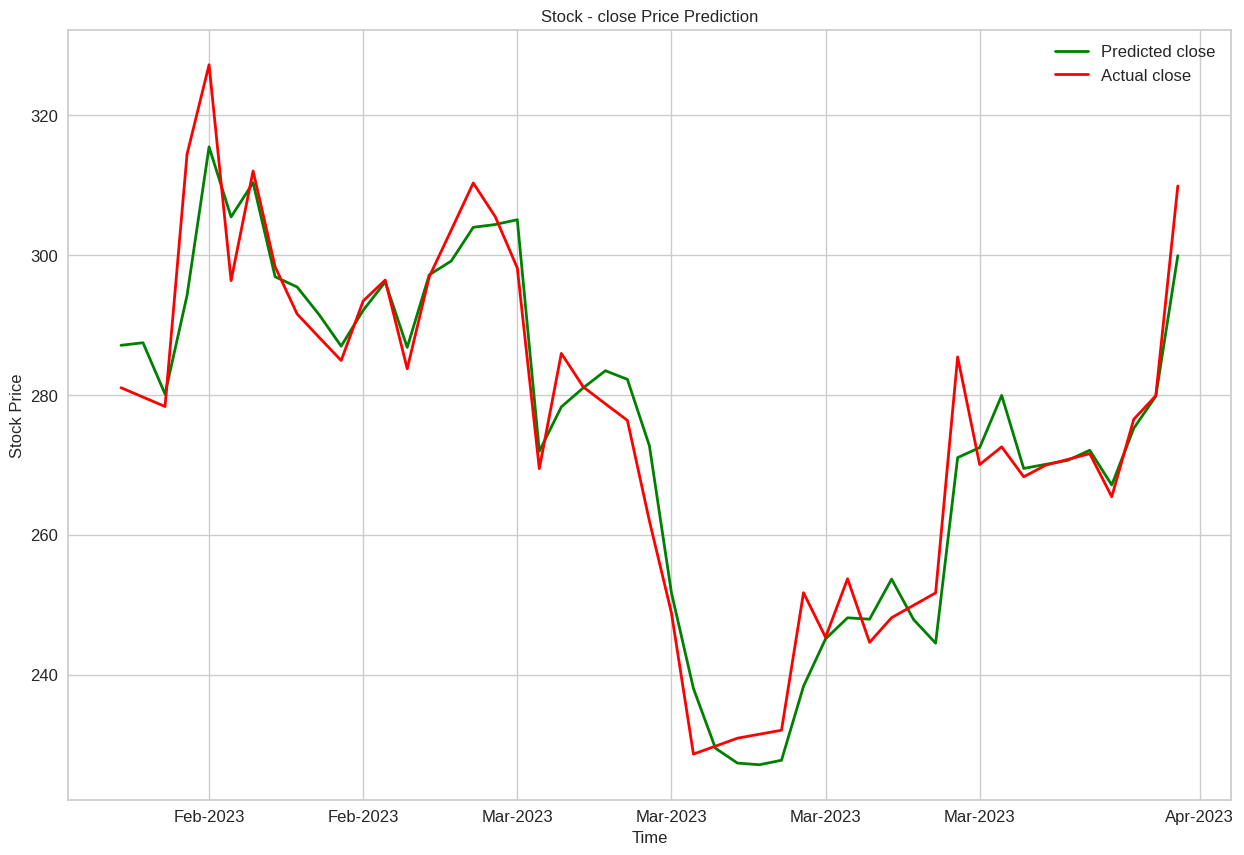

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

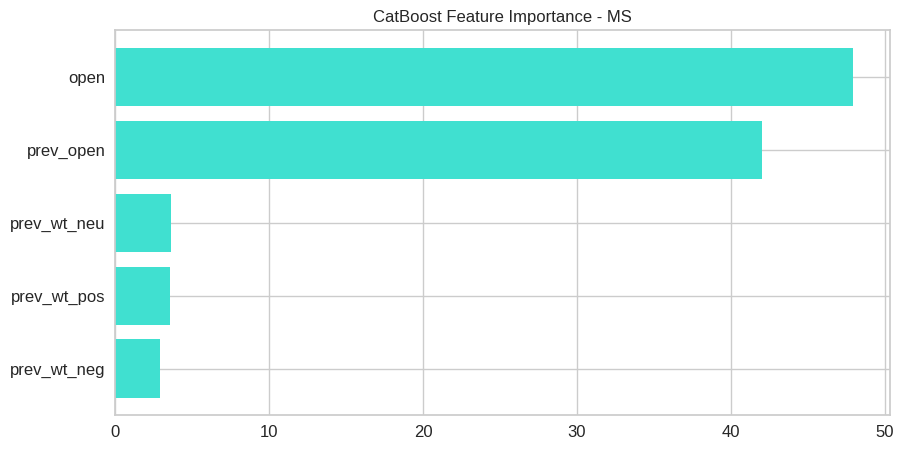

RMSE:			0.062865
MSE:			0.003952
MAE:			0.049612
R2 Score:		0.926154
Adj. R2 Score:		0.924180
Exp. Variance Score:	0.936513
Max Error:		0.189636
Predicted 	 Value
[0.89510647] 	 [0.92596937]
[0.90212463] 	 [0.93576177]
[0.91050973] 	 [0.94516247]
[0.92670523] 	 [0.98942405]
[0.88482736] 	 [1.]
[0.92966803] 	 [0.95064622]
[0.91890316] 	 [0.94829612]
[0.92848187] 	 [0.91147661]
[0.91957991] 	 [0.8930669]
[0.92861742] 	 [0.88366619]
[0.91586678] 	 [0.8742656]
[0.88491988] 	 [0.86055601]
[0.86193498] 	 [0.88679984]
[0.88876449] 	 [0.87739894]
[0.90178668] 	 [0.85781425]
[0.91180693] 	 [0.84802185]
[0.91323623] 	 [0.83822933]
[0.85925924] 	 [0.83039553]
[0.85449294] 	 [0.81825303]
[0.79719397] 	 [0.81394437]
[0.89302185] 	 [0.90207599]
[0.84726675] 	 [0.9028593]
[0.89901545] 	 [0.903251]
[0.9235023] 	 [0.90403427]
[0.92794923] 	 [0.81316082]
[0.84383914] 	 [0.80689384]
[0.85160244] 	 [0.66196611]
[0.76230514] 	 [0.57775169]
[0.63340372] 	 [0.53740688]
[0.57003918] 	 [0.51703868]
[0.5384274]

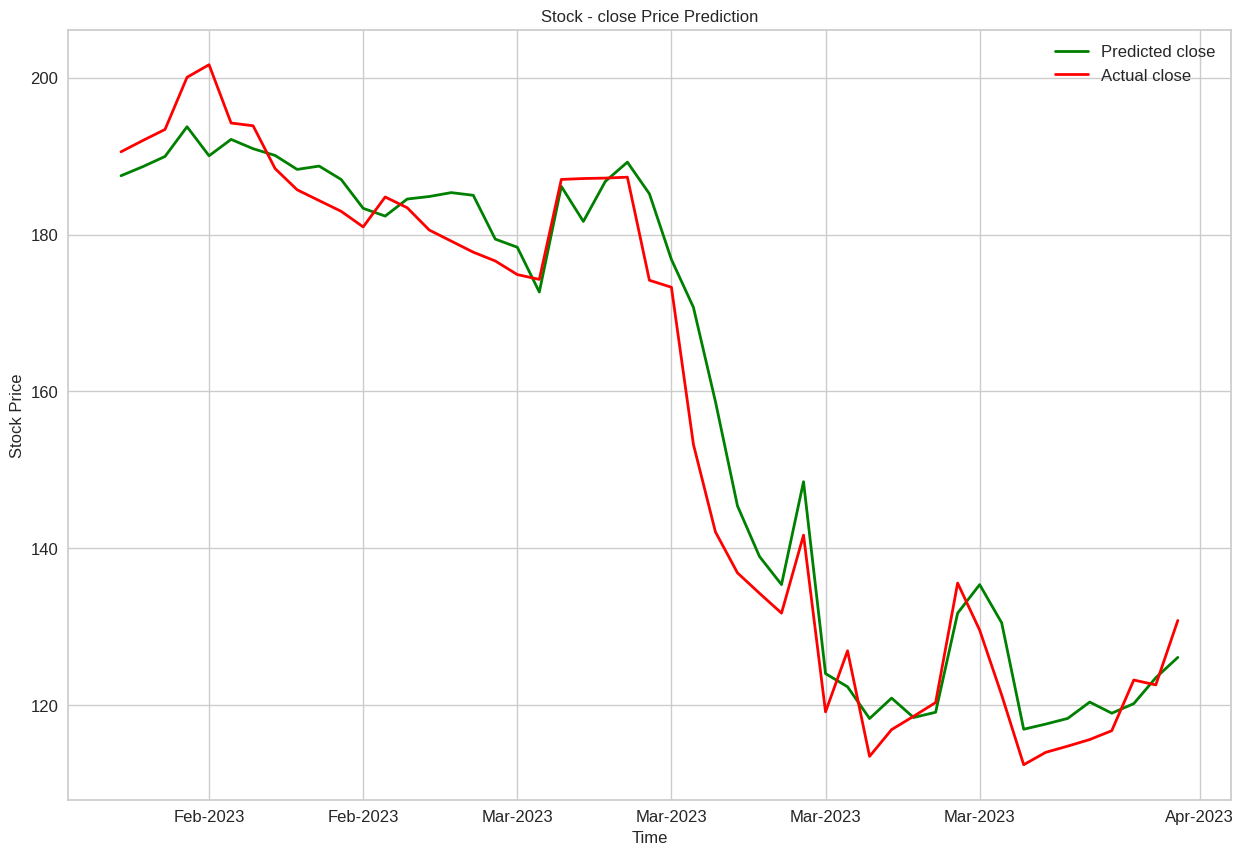

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

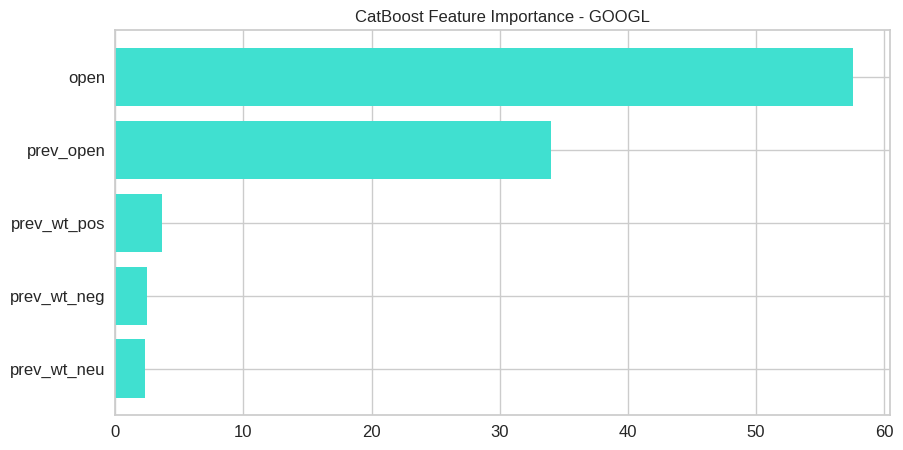

RMSE:			0.045158
MSE:			0.002039
MAE:			0.036502
R2 Score:		0.880161
Adj. R2 Score:		0.876956
Exp. Variance Score:	0.887322
Max Error:		0.109612
Predicted 	 Value
[0.30250431] 	 [0.28874513]
[0.30234446] 	 [0.28900387]
[0.30594598] 	 [0.28926262]
[0.27250344] 	 [0.29107372]
[0.27432122] 	 [0.34954725]
[0.3170397] 	 [0.31254855]
[0.30167233] 	 [0.28253551]
[0.27348496] 	 [0.24941784]
[0.24979407] 	 [0.23285898]
[0.24869604] 	 [0.22457955]
[0.24895505] 	 [0.21630014]
[0.22022903] 	 [0.21267792]
[0.20804109] 	 [0.19301419]
[0.16062059] 	 [0.14747728]
[0.13719298] 	 [0.15705044]
[0.13270473] 	 [0.16196636]
[0.13171687] 	 [0.16662361]
[0.13261489] 	 [0.1715394]
[0.13843734] 	 [0.17930144]
[0.12682861] 	 [0.22173349]
[0.22711924] 	 [0.26442436]
[0.24062385] 	 [0.28357049]
[0.27929259] 	 [0.29314358]
[0.28517452] 	 [0.30271659]
[0.31252849] 	 [0.26985771]
[0.27275153] 	 [0.27994824]
[0.28508412] 	 [0.23001292]
[0.22942251] 	 [0.18628711]
[0.20680639] 	 [0.19249676]
[0.14927335] 	 [0.19560154]

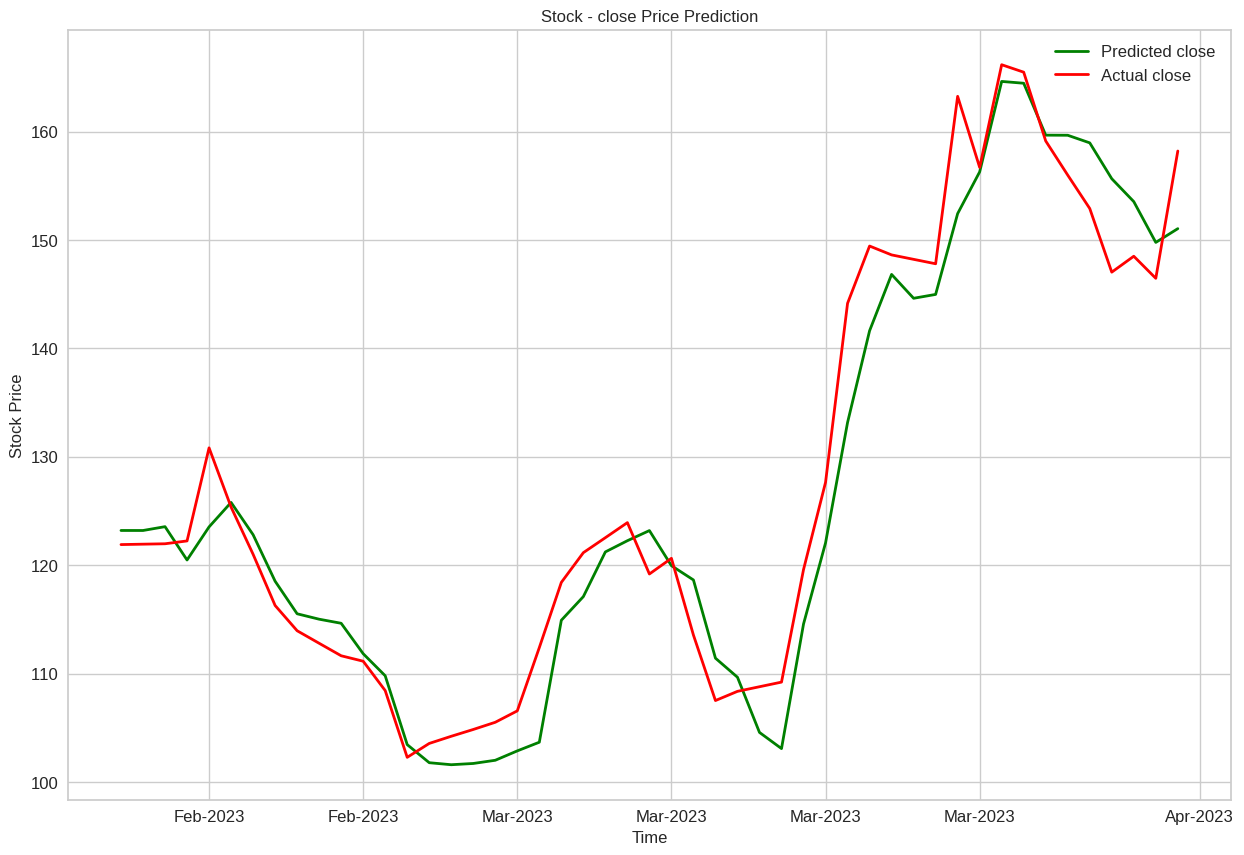

======FINISHED WORKING ON GOOGL======


In [150]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, both_open_dfs, output_label='close')
train_and_test_model(categories, tickers, both_open_norm_dfs, unscaled_op_labels)

# **Predicting High Value**

In [151]:
both_open_dfs = append_prev_day_value(categories, tickers, merged_dfs, output_label='high')

both_open_dfs['TSLA']

,date,open,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,high
0,2022-08-02,294.003326,301.276672,-16.876412,-26.904634,-41.171774,307.833344
1,2022-08-03,305.000000,294.003326,-22.682993,-25.073643,-37.357318,309.549988
2,2022-08-04,311.000000,305.000000,-2.331892,-6.009396,-13.196395,313.606659
3,2022-08-05,302.670013,311.000000,-1.167563,-2.196746,-3.635691,304.606659
4,2022-08-06,298.840000,302.670013,-16.216868,-16.855830,-160.879937,304.900000
...,...,...,...,...,...,...,...
237,2023-03-27,194.419998,193.720000,-14.594635,-21.290344,-30.107518,197.389999
238,2023-03-28,192.000000,194.419998,-232.793960,-281.636459,-465.958222,192.350006
239,2023-03-29,193.130005,192.000000,-13.191043,-12.029059,-33.769606,195.289993
240,2023-03-30,195.580002,193.130005,-50.816797,-73.301693,-115.862161,197.330002


In [152]:
both_open_norm_dfs = normalize_datasets(categories, tickers, both_open_dfs,True,output_label='high')

Data dimensions for TSLA: (242, 6) 

Data dimensions for MS: (242, 6) 

Data dimensions for GOOGL: (242, 6) 



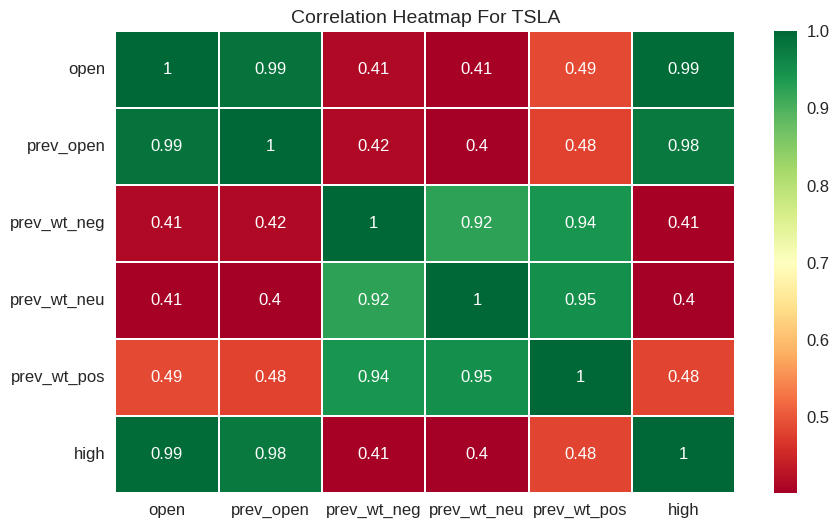

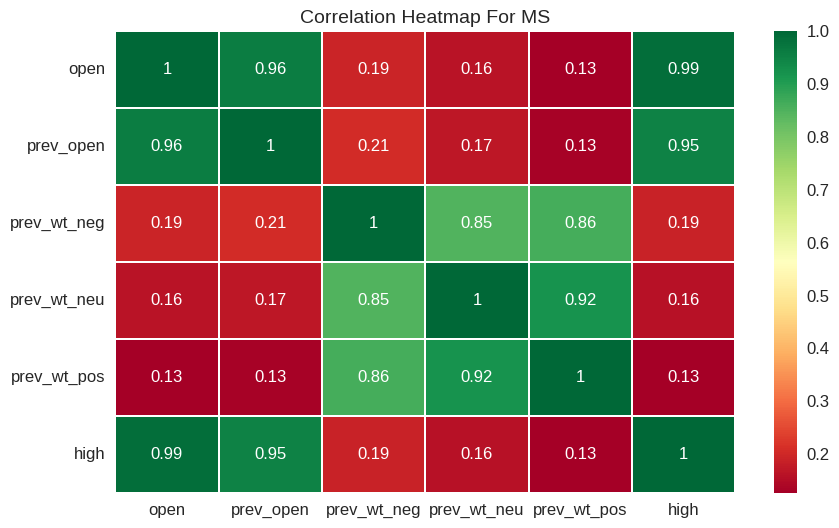

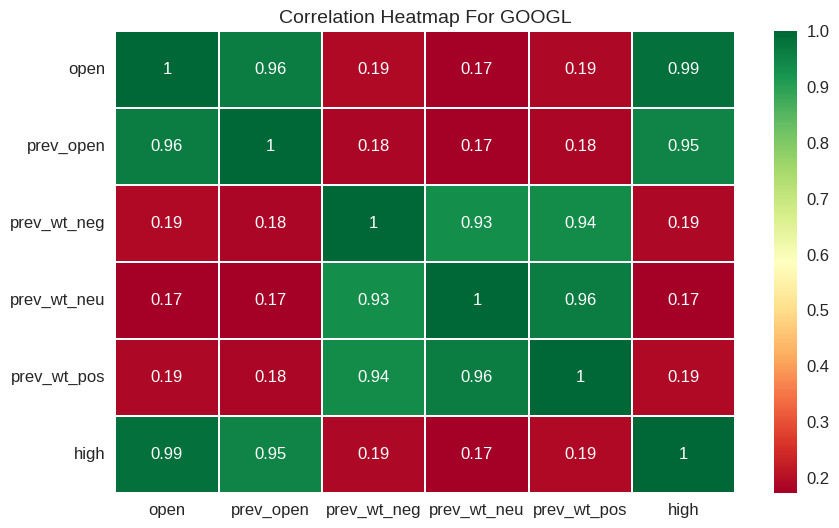

In [153]:
plot_corr_heatmaps(categories, tickers, both_open_norm_dfs)

======CURRENTLY WORKING ON TSLA======


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

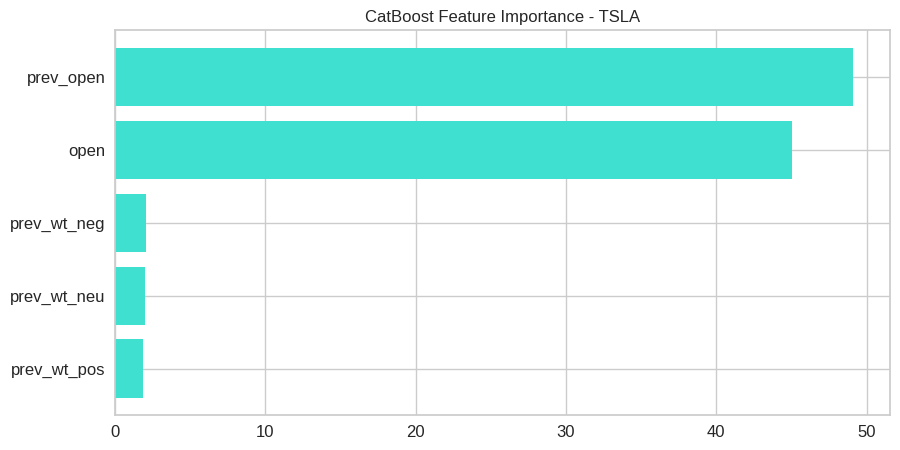

RMSE:			0.024196
MSE:			0.000585
MAE:			0.019272
R2 Score:		0.776602
Adj. R2 Score:		0.770628
Exp. Variance Score:	0.779931
Max Error:		0.078823
Predicted 	 Value
[0.46418877] 	 [0.44106778]
[0.45845647] 	 [0.4288953]
[0.42640006] 	 [0.41667355]
[0.40447883] 	 [0.48330191]
[0.48083209] 	 [0.50715405]
[0.53231662] 	 [0.52188911]
[0.50762833] 	 [0.47650106]
[0.46032023] 	 [0.47965506]
[0.46201615] 	 [0.48123206]
[0.46100974] 	 [0.48202056]
[0.45330349] 	 [0.48275981]
[0.45538198] 	 [0.44471463]
[0.46008584] 	 [0.46023821]
[0.45291128] 	 [0.42342506]
[0.45711608] 	 [0.45235321]
[0.45815343] 	 [0.46684191]
[0.46751182] 	 [0.48133061]
[0.48123503] 	 [0.49025052]
[0.51356112] 	 [0.47039015]
[0.43228807] 	 [0.4041068]
[0.41462928] 	 [0.4372731]
[0.43969667] 	 [0.43264068]
[0.45417254] 	 [0.43032446]
[0.46511421] 	 [0.42800827]
[0.4321359] 	 [0.40632444]
[0.39719716] 	 [0.36837784]
[0.39741621] 	 [0.36187267]
[0.33836725] 	 [0.32791785]
[0.31641352] 	 [0.32560166]
[0.31515979] 	 [0.32446819]
[

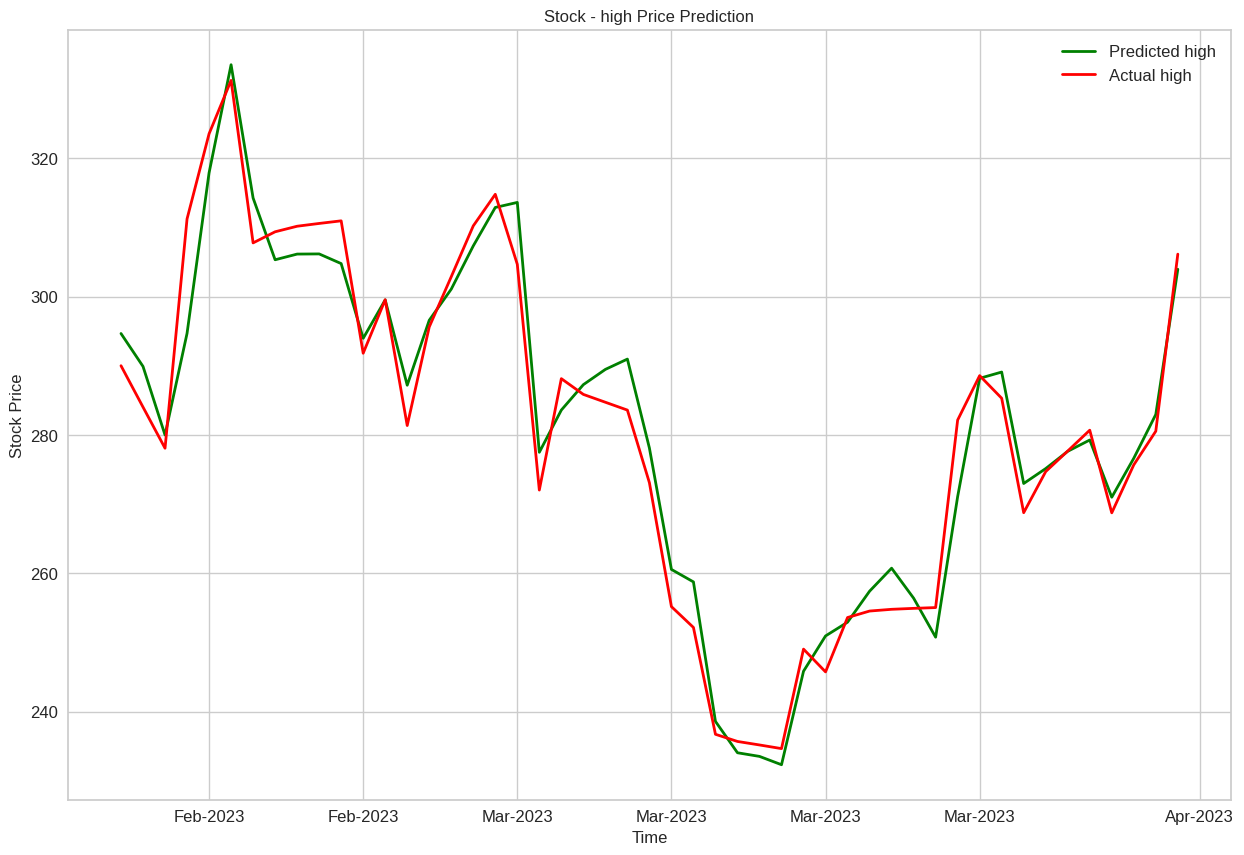

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

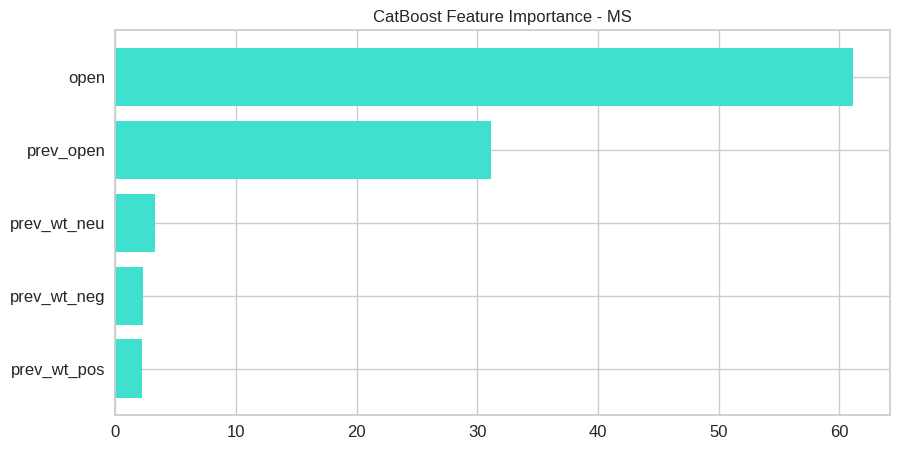

RMSE:			0.037185
MSE:			0.001383
MAE:			0.028686
R2 Score:		0.976386
Adj. R2 Score:		0.975754
Exp. Variance Score:	0.976729
Max Error:		0.102192
Predicted 	 Value
[0.92535073] 	 [0.92194919]
[0.9338454] 	 [0.93445458]
[0.91878599] 	 [0.94696006]
[0.93430759] 	 [1.]
[0.92090253] 	 [0.99870638]
[0.93611882] 	 [0.96765847]
[0.92088122] 	 [0.95817157]
[0.93619287] 	 [0.93617946]
[0.92337776] 	 [0.92496773]
[0.94001158] 	 [0.91936186]
[0.93089474] 	 [0.91418722]
[0.91366257] 	 [0.87408372]
[0.90202065] 	 [0.88917635]
[0.90400751] 	 [0.87020286]
[0.91082973] 	 [0.88098324]
[0.91845925] 	 [0.88658911]
[0.93394232] 	 [0.89176388]
[0.90216569] 	 [0.84044856]
[0.84075995] 	 [0.81759392]
[0.79750574] 	 [0.80077637]
[0.88617106] 	 [0.89003896]
[0.89604298] 	 [0.90642525]
[0.90169249] 	 [0.91461844]
[0.93583926] 	 [0.9228115]
[0.94078731] 	 [0.88227699]
[0.84919547] 	 [0.80638211]
[0.84917118] 	 [0.78266485]
[0.75346232] 	 [0.65588626]
[0.58932558] 	 [0.59508409]
[0.53164588] 	 [0.56446744]
[0.5032

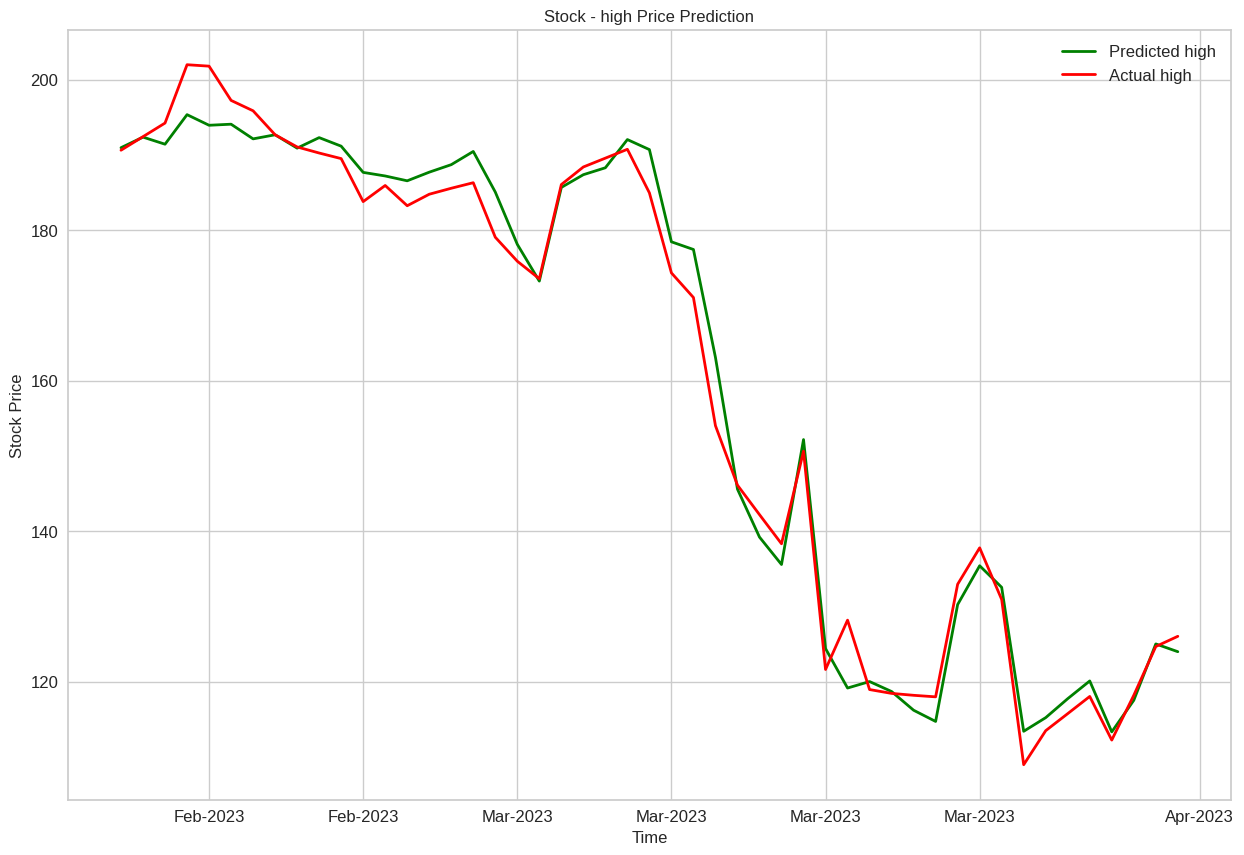

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

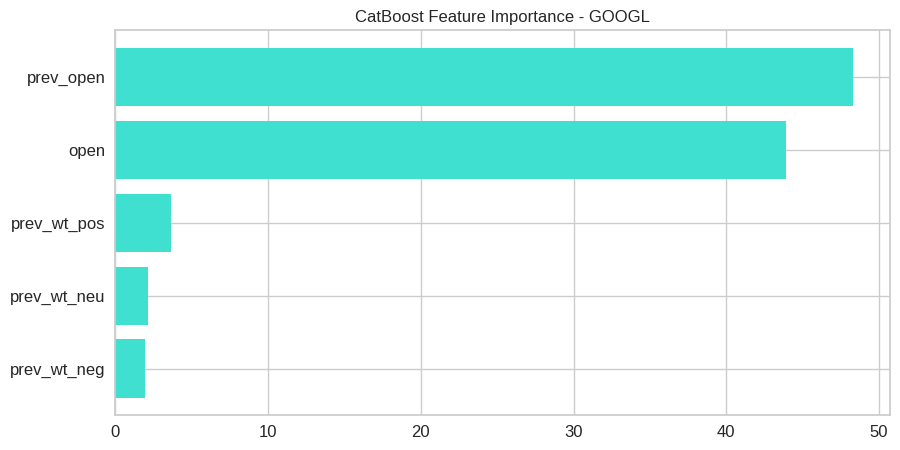

RMSE:			0.044982
MSE:			0.002023
MAE:			0.035590
R2 Score:		0.898313
Adj. R2 Score:		0.895595
Exp. Variance Score:	0.899675
Max Error:		0.129150
Predicted 	 Value
[0.28492607] 	 [0.26315796]
[0.28231408] 	 [0.25229747]
[0.27066351] 	 [0.24171538]
[0.24153155] 	 [0.23196882]
[0.23743736] 	 [0.29518254]
[0.29453678] 	 [0.310777]
[0.27069293] 	 [0.25174047]
[0.22787391] 	 [0.21748823]
[0.21150424] 	 [0.20022285]
[0.20585721] 	 [0.19159015]
[0.20246178] 	 [0.18323588]
[0.17862298] 	 [0.15566704]
[0.16335077] 	 [0.15093301]
[0.13981413] 	 [0.09384577]
[0.11176178] 	 [0.09774444]
[0.1118255] 	 [0.09969375]
[0.11109952] 	 [0.10136471]
[0.11272601] 	 [0.13116139]
[0.11250218] 	 [0.1255918]
[0.11784384] 	 [0.16040104]
[0.17367346] 	 [0.20077988]
[0.20459817] 	 [0.23196888]
[0.22234249] 	 [0.24756342]
[0.23781943] 	 [0.26315798]
[0.28237037] 	 [0.25480368]
[0.22863929] 	 [0.26287945]
[0.24097194] 	 [0.25090508]
[0.19850595] 	 [0.17460327]
[0.1721599] 	 [0.17154003]
[0.13571775] 	 [0.16986919]
[0

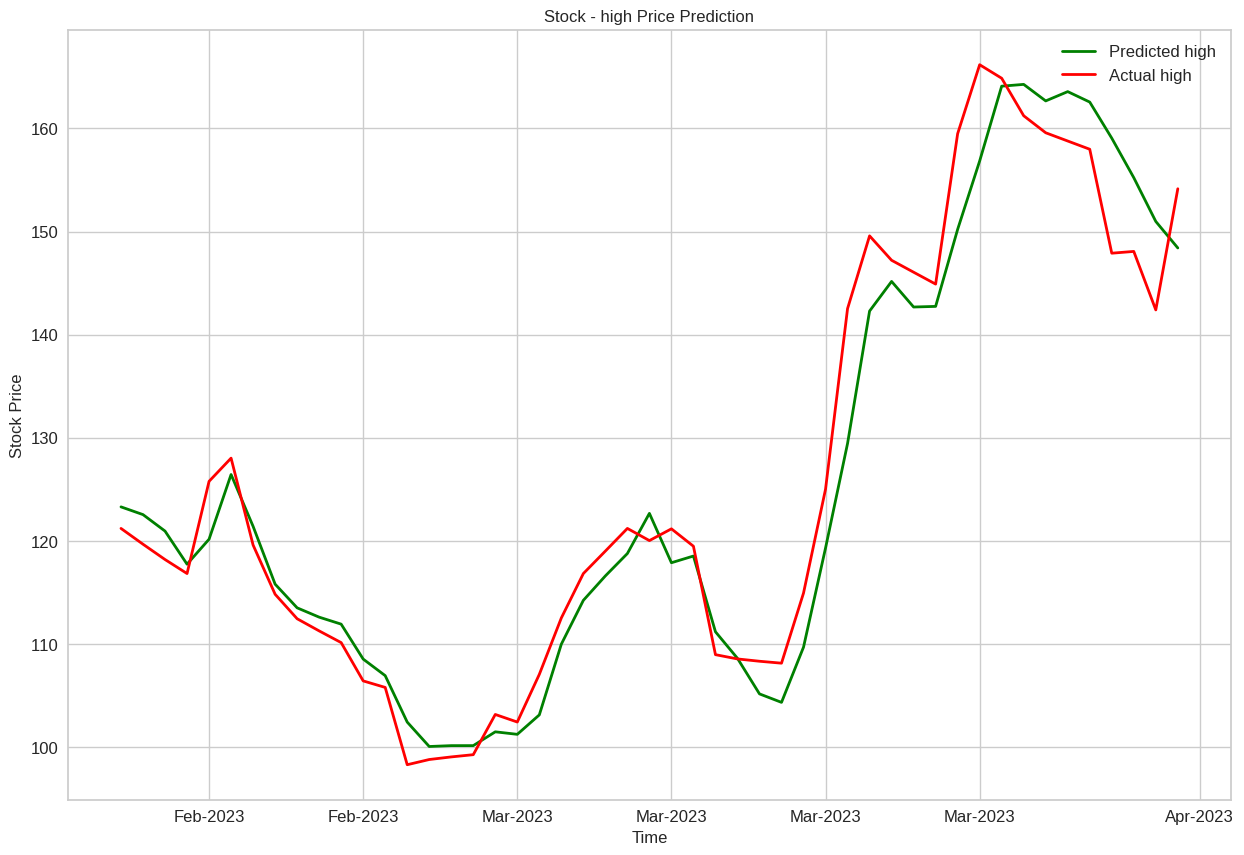

======FINISHED WORKING ON GOOGL======


In [154]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, both_open_dfs, output_label='high')
train_and_test_model(categories, tickers, both_open_norm_dfs, unscaled_op_labels,output_label='high')

# **Predicting Low Value**

In [155]:
both_open_dfs = append_prev_day_value(categories, tickers, merged_dfs, output_label='low')

both_open_dfs['TSLA']

,date,open,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,low
0,2022-08-02,294.003326,301.276672,-16.876412,-26.904634,-41.171774,292.666656
1,2022-08-03,305.000000,294.003326,-22.682993,-25.073643,-37.357318,301.149994
2,2022-08-04,311.000000,305.000000,-2.331892,-6.009396,-13.196395,305.000000
3,2022-08-05,302.670013,311.000000,-1.167563,-2.196746,-3.635691,285.543335
4,2022-08-06,298.840000,302.670013,-16.216868,-16.855830,-160.879937,287.320000
...,...,...,...,...,...,...,...
237,2023-03-27,194.419998,193.720000,-14.594635,-21.290344,-30.107518,189.940002
238,2023-03-28,192.000000,194.419998,-232.793960,-281.636459,-465.958222,185.429993
239,2023-03-29,193.130005,192.000000,-13.191043,-12.029059,-33.769606,189.440002
240,2023-03-30,195.580002,193.130005,-50.816797,-73.301693,-115.862161,194.419998


In [156]:
both_open_norm_dfs = normalize_datasets(categories, tickers, both_open_dfs,True,output_label='low')

Data dimensions for TSLA: (242, 6) 

Data dimensions for MS: (242, 6) 

Data dimensions for GOOGL: (242, 6) 



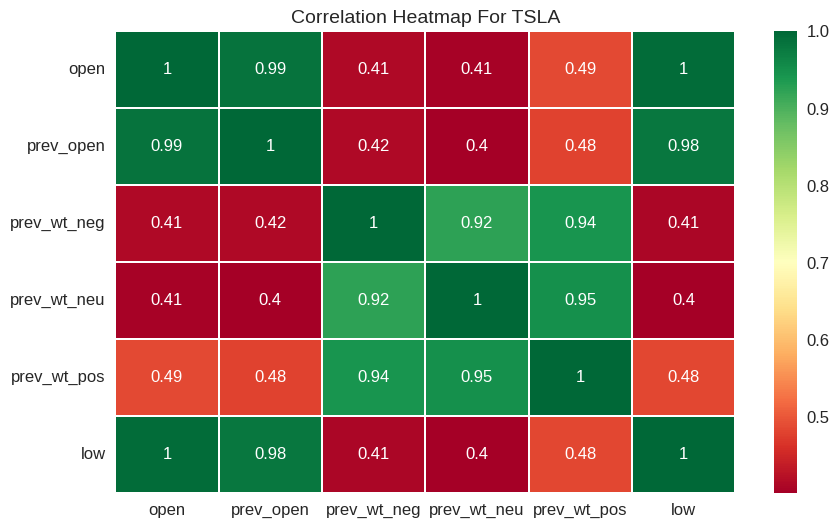

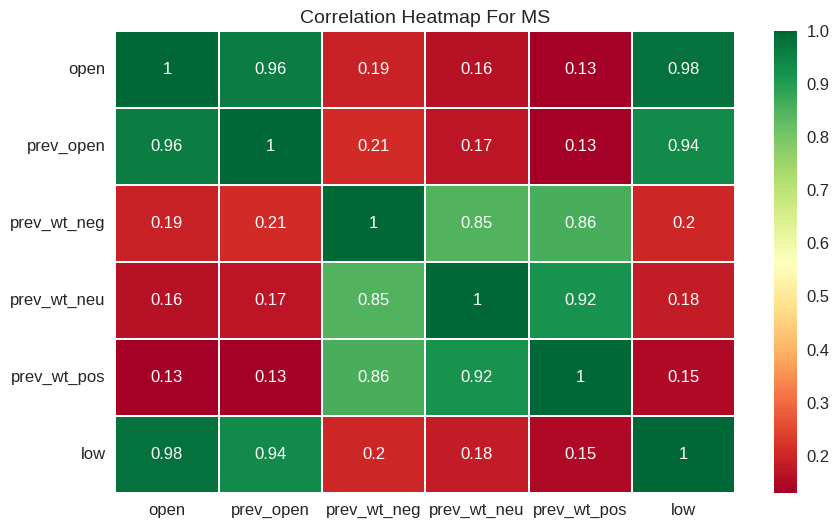

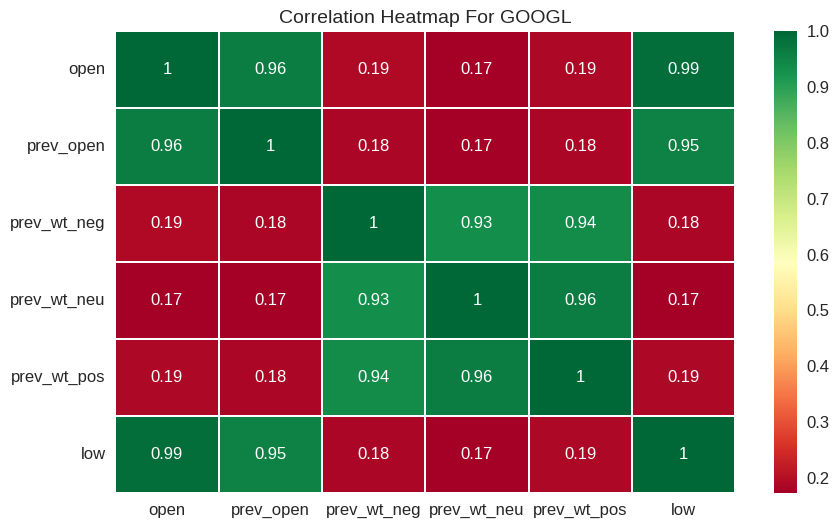

In [157]:
plot_corr_heatmaps(categories, tickers, both_open_norm_dfs)

======CURRENTLY WORKING ON TSLA======


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

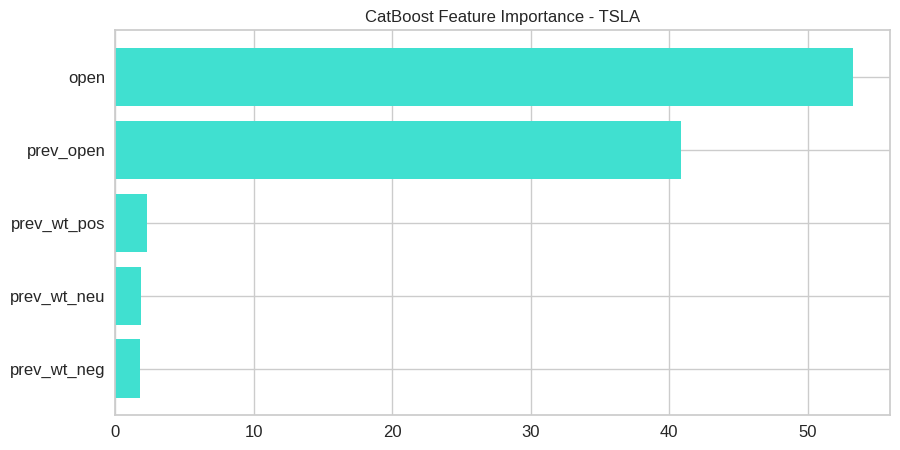

RMSE:			0.020799
MSE:			0.000433
MAE:			0.017256
R2 Score:		0.829707
Adj. R2 Score:		0.825154
Exp. Variance Score:	0.843244
Max Error:		0.050538
Predicted 	 Value
[0.44512239] 	 [0.43401878]
[0.44409491] 	 [0.42754089]
[0.41931672] 	 [0.421063]
[0.41001965] 	 [0.43004372]
[0.4859899] 	 [0.51185164]
[0.52278625] 	 [0.49089662]
[0.4691941] 	 [0.46959811]
[0.44579099] 	 [0.46891106]
[0.44834589] 	 [0.46856754]
[0.44389965] 	 [0.46842031]
[0.43991394] 	 [0.46822402]
[0.43571409] 	 [0.44152724]
[0.44369461] 	 [0.46385635]
[0.44461348] 	 [0.4465329]
[0.4461699] 	 [0.46729159]
[0.44544494] 	 [0.4776464]
[0.44886528] 	 [0.48805026]
[0.49020489] 	 [0.50026995]
[0.49892018] 	 [0.47460377]
[0.41842681] 	 [0.41321098]
[0.40795638] 	 [0.44692551]
[0.43351204] 	 [0.44550232]
[0.44820434] 	 [0.44481527]
[0.45397913] 	 [0.44407916]
[0.42912278] 	 [0.41365271]
[0.40327922] 	 [0.38371697]
[0.39095984] 	 [0.34695981]
[0.33054835] 	 [0.32698635]
[0.32083384] 	 [0.3158954]
[0.31468161] 	 [0.31034993]
[0.32

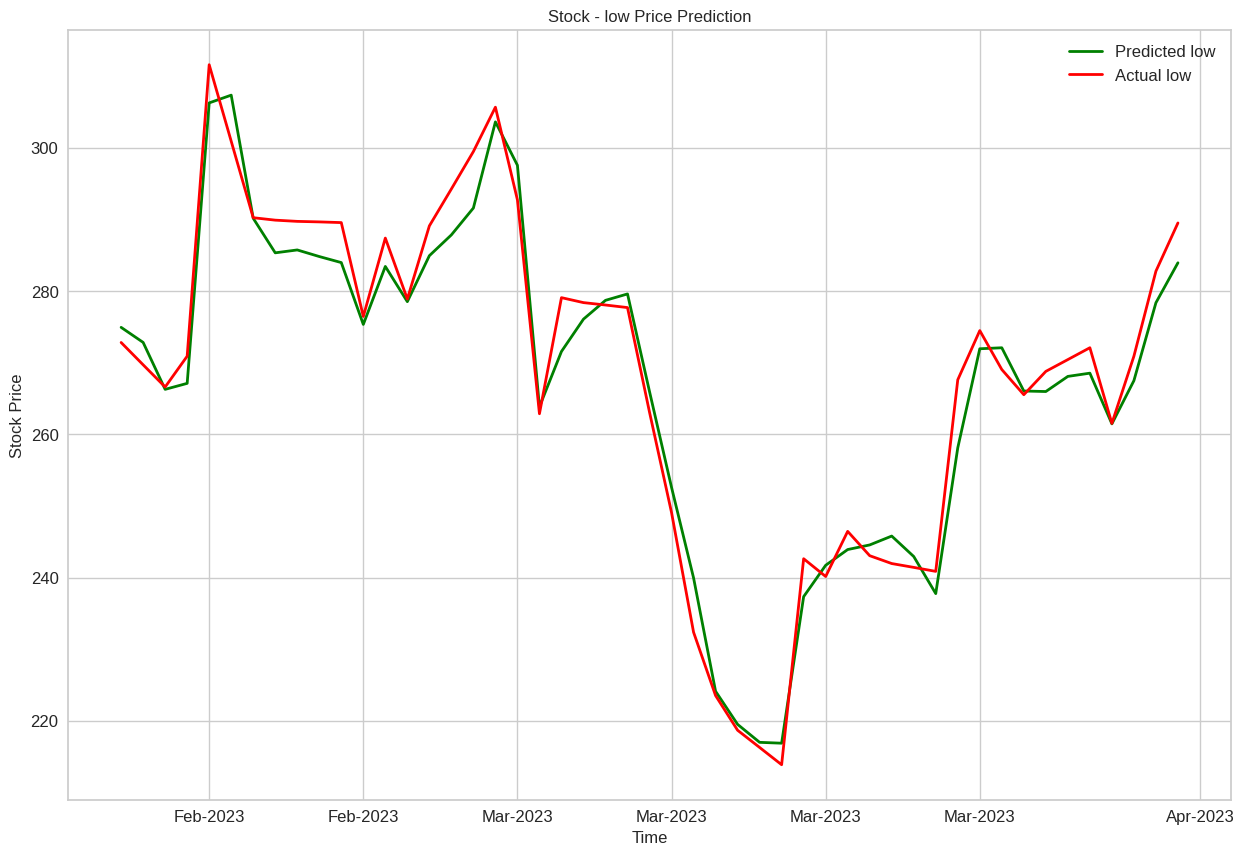

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

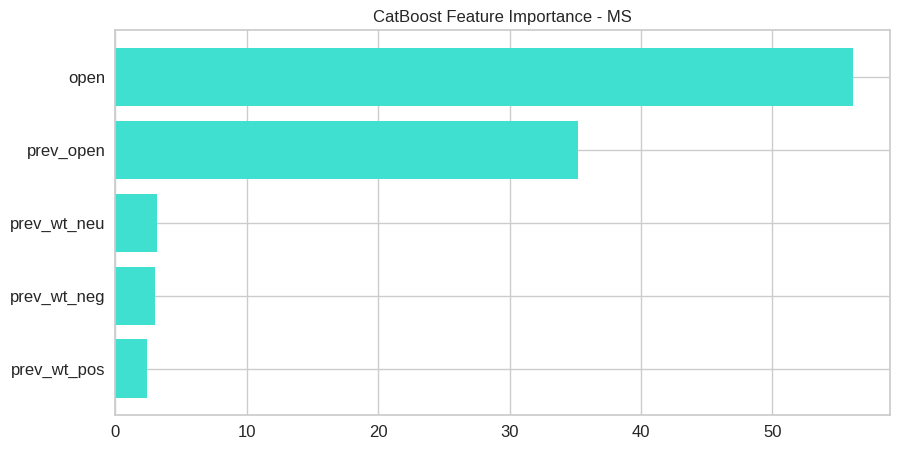

RMSE:			0.056626
MSE:			0.003207
MAE:			0.043173
R2 Score:		0.945656
Adj. R2 Score:		0.944203
Exp. Variance Score:	0.955233
Max Error:		0.164122
Predicted 	 Value
[0.91469834] 	 [0.93395087]
[0.9262994] 	 [0.93999195]
[0.92663906] 	 [0.94603319]
[0.93767421] 	 [0.97865489]
[0.89675279] 	 [1.]
[0.93264686] 	 [0.97221096]
[0.91469501] 	 [0.95167149]
[0.94368419] 	 [0.92911801]
[0.93489415] 	 [0.91784133]
[0.94121653] 	 [0.91220299]
[0.92728178] 	 [0.90656465]
[0.90298436] 	 [0.88401141]
[0.87943825] 	 [0.88723307]
[0.90807826] 	 [0.88360859]
[0.91632622] 	 [0.88320581]
[0.92256154] 	 [0.88280307]
[0.92878563] 	 [0.88240041]
[0.87920523] 	 [0.86951278]
[0.86534625] 	 [0.82923892]
[0.80380231] 	 [0.79782535]
[0.88043626] 	 [0.87716461]
[0.85970511] 	 [0.91018929]
[0.90755713] 	 [0.92670158]
[0.93298807] 	 [0.94361652]
[0.94117379] 	 [0.85783332]
[0.8645068] 	 [0.83326626]
[0.83665673] 	 [0.68868295]
[0.7505093] 	 [0.58638759]
[0.64020812] 	 [0.53443419]
[0.57136926] 	 [0.50865892]
[0.53684

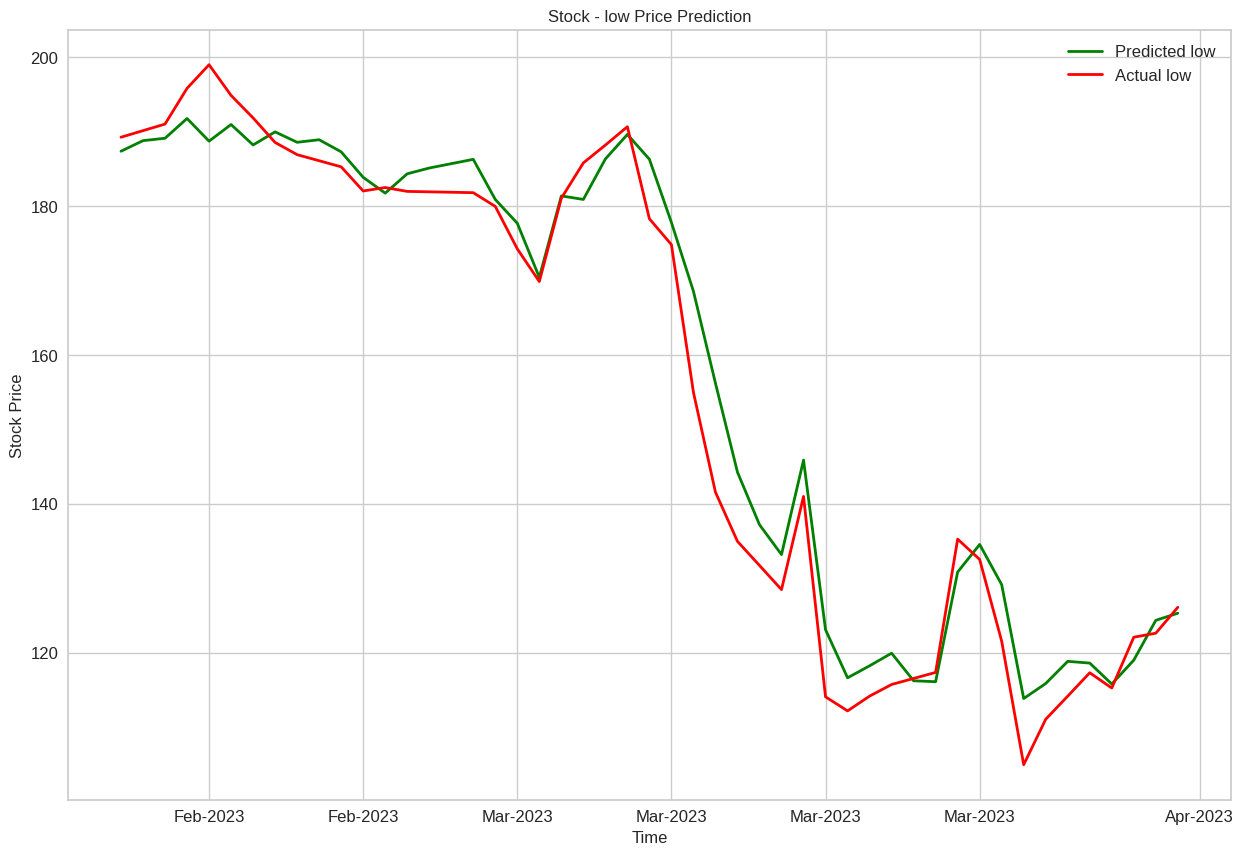

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

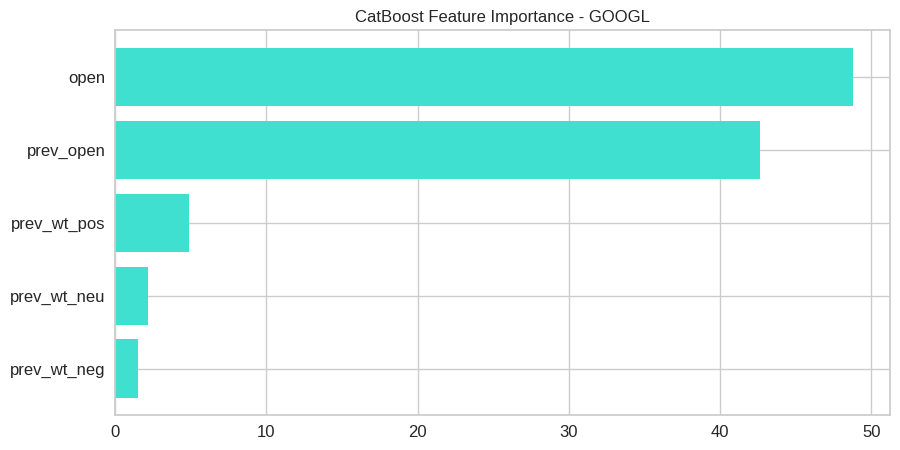

RMSE:			0.037457
MSE:			0.001403
MAE:			0.030204
R2 Score:		0.915029
Adj. R2 Score:		0.912757
Exp. Variance Score:	0.934954
Max Error:		0.093531
Predicted 	 Value
[0.27704809] 	 [0.28686335]
[0.27865652] 	 [0.28418239]
[0.28561077] 	 [0.28150132]
[0.26362705] 	 [0.23914223]
[0.24770695] 	 [0.28981247]
[0.28887237] 	 [0.30563006]
[0.28218778] 	 [0.26461132]
[0.25044209] 	 [0.24477221]
[0.2207826] 	 [0.23485264]
[0.22389988] 	 [0.2297588]
[0.20573421] 	 [0.224665]
[0.19956468] 	 [0.19490628]
[0.19091977] 	 [0.17211811]
[0.14884202] 	 [0.14048272]
[0.12673919] 	 [0.15067034]
[0.12293547] 	 [0.15576417]
[0.12188324] 	 [0.1608579]
[0.12031519] 	 [0.16032181]
[0.12594239] 	 [0.16970513]
[0.12221597] 	 [0.16756031]
[0.18894225] 	 [0.24423593]
[0.20703044] 	 [0.26487944]
[0.23480758] 	 [0.27533521]
[0.2619937] 	 [0.28579097]
[0.27826557] 	 [0.27319041]
[0.24980776] 	 [0.28579097]
[0.25326745] 	 [0.22949076]
[0.19942734] 	 [0.18927629]
[0.18249576] 	 [0.1761395]
[0.13865843] 	 [0.16943709]
[0.1

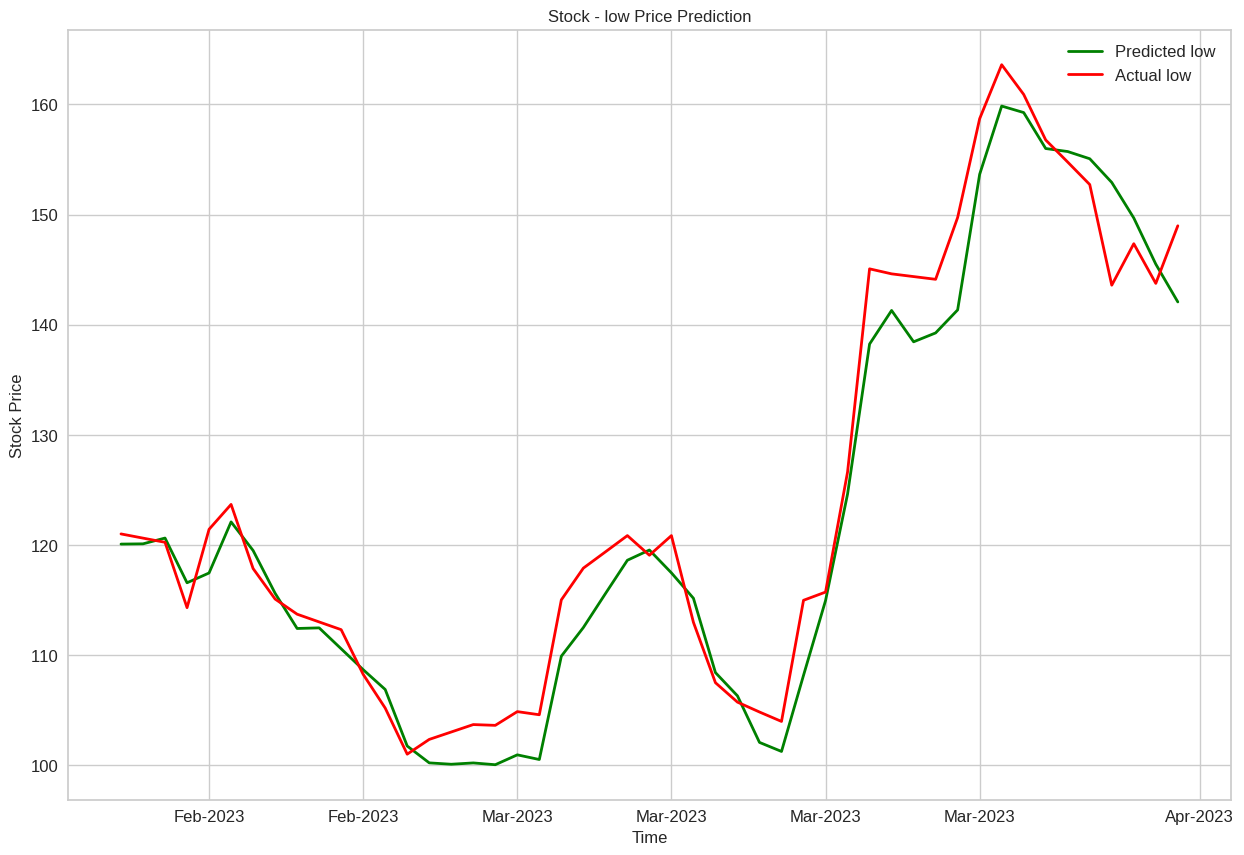

======FINISHED WORKING ON GOOGL======


In [158]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, both_open_dfs, output_label='low')
train_and_test_model(categories, tickers, both_open_norm_dfs, unscaled_op_labels,output_label='low')